## Model Interpretation

### By:
[Jose R. Zapata](https://joserzapata.github.io/)

### Date:
2025-01-30

### Description:

Interpretation of the model trained in the previous step. The goal is to understand the model's behavior and how it is making predictions.

<https://github.com/JoseRZapata/demo-data-science-template/blob/main/notebooks/5-models/02-jrz-basic_algorithms_model_selection-2024_11_02.ipynb>

## 📚 Import  libraries

In [22]:
# base libraries for data science

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

## 💾 Load model

In [23]:
DATA_MODEL = Path.cwd().resolve().parents[1] / "models"

titanic_model = load(DATA_MODEL / "titanic_classification-random_forest-v1.joblib")

In [24]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


## Model Interpretation

### Feature Importance
Random forest as a method to get feature importance. This method is computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.. The more a feature decreases the impurity, the more important it is considered.

In [25]:
features = titanic_model["preprocessor"].get_feature_names_out()
importances = titanic_model["model"].feature_importances_

dfFeatures = pd.DataFrame({"Features": features, "Importances": importances})
dfFeatures.sort_values(by="Importances", ascending=False)

,Features,Importances
5,categoric__sex_male,0.281052
4,categoric__sex_female,0.263076
9,categoric ordinal__pclass,0.168484
1,numeric__fare,0.111280
0,numeric__age,0.093817
2,numeric__sibsp,0.028429
3,numeric__parch,0.026425
6,categoric__embarked_C,0.015069
8,categoric__embarked_S,0.007535
7,categoric__embarked_Q,0.004832


In [26]:
titanic_model.named_steps["model"].feature_importances_

array([0.09381687, 0.11127966, 0.02842946, 0.02642524, 0.26307643,
       0.28105184, 0.01506934, 0.0048317 , 0.00753499, 0.16848448])

In [27]:
std = np.std([tree.feature_importances_ for tree in titanic_model["model"].estimators_], axis=0)

dfFeatures["std"] = std
dfFeatures

,Features,Importances,std
0,numeric__age,0.093817,0.047078
1,numeric__fare,0.111280,0.068099
2,numeric__sibsp,0.028429,0.026219
3,numeric__parch,0.026425,0.027533
4,categoric__sex_female,0.263076,0.263597
5,categoric__sex_male,0.281052,0.262374
6,categoric__embarked_C,0.015069,0.021990
7,categoric__embarked_Q,0.004832,0.011320
8,categoric__embarked_S,0.007535,0.013045
9,categoric ordinal__pclass,0.168484,0.083930


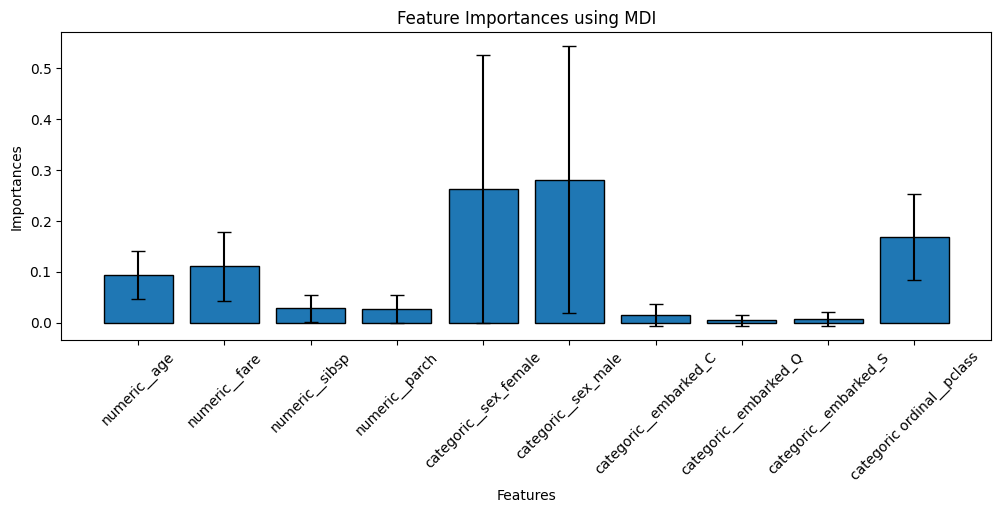

In [28]:
# Crear el bar plot
plt.figure(figsize=(12, 4))
plt.bar(
    dfFeatures["Features"],
    dfFeatures["Importances"],
    yerr=dfFeatures["std"],
    capsize=5,
    edgecolor="black",
)

# Añadir etiquetas y título
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Feature Importances using MDI")
plt.xticks(rotation=45);

###  Feature permutation

#### 💾 Load data

In [29]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

titanic_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/titanic_type_fixed.parquet", engine="pyarrow"
)

selected_features = [
    "pclass",
    "sex",
    "age",
    "sibsp",
    "parch",
    "fare",
    "embarked",
    "survived",
]

titanic_features = titanic_df[selected_features]
titanic_features.loc[:, "survived"] = titanic_features["survived"].astype(bool)
titanic_features = titanic_features.drop_duplicates()

In [30]:
X_features = titanic_features.drop("survived", axis="columns")
Y_target = titanic_features["survived"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [31]:
imps = permutation_importance(
    titanic_model, x_test, y_test, scoring="recall", n_repeats=10, random_state=42, n_jobs=8
)

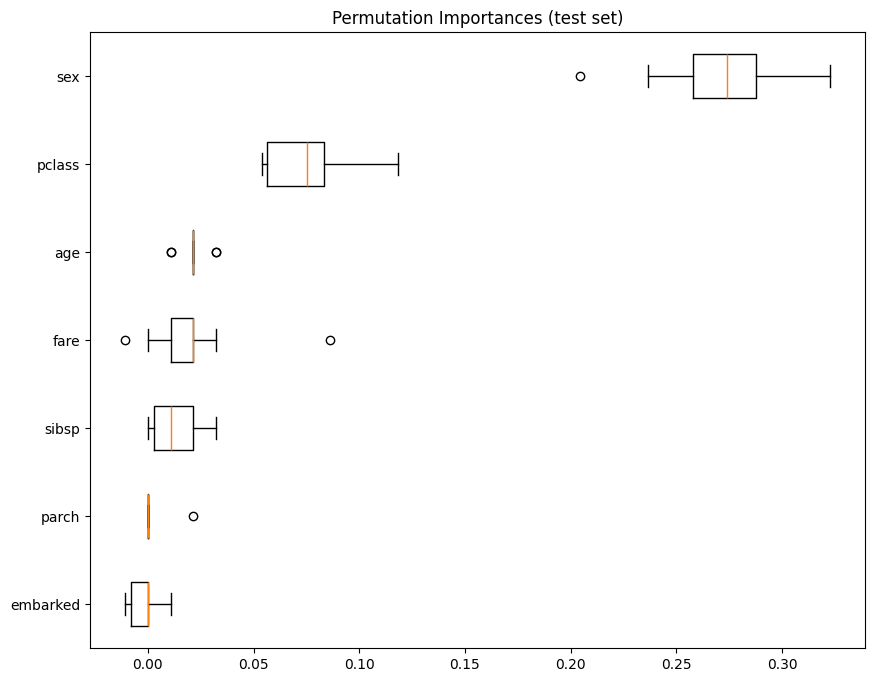

In [32]:
fig = plt.figure(figsize=(10, 8))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(
    imps.importances[perm_sorted_idx].T, vert=False, tick_labels=x_test.columns[perm_sorted_idx]
)
plt.title("Permutation Importances (test set)");

Variables with more predictive power will have a higher impact on the model's performance when permuted.Based on the results, the most important features are:
- Sex
- Pclass

With moderate importance:
- Age
- Fare

The results are consistent with the feature analysis.

## 📊 Analysis of Results

The analysis of feature importances reveals that gender (both male and female) is the most significant predictor in the model, followed by passenger class and fare. Age, port of embarkation, and the number of family members aboard also contribute to the model's predictions, but to a lesser extent. Understanding these feature importances helps in interpreting the model's decision-making process and provides insights into the factors that most influence the target variable.

## 📖 References

- <https://joserzapata.github.io/courses/python-ciencia-datos/ml/>
- <https://joserzapata.github.io/courses/python-ciencia-datos/clasificacion/>
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition - Aurélien Géron
- <https://joserzapata.github.io/post/lista-proyecto-machine-learning/>